In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [132]:
# functions used in model

def sir(f, t, beta, r, N):
    '''
    Generates SIR model.
    
    Arguments:
        f - S, I and R values
        t - time
        beta - transmission rate
        r - recovery rate
    '''
    
    S, I, R = f
    dS = -beta * S * I / N
    dI = beta * S * I / N - r * I
    dR = r * I

    return [dS, dI, dR]

def si(f, t, beta, N):
    '''
    Generates SI model.
    
    Arguments:
        f - S, I and R values
        t - time
        beta - transmission rate
    '''
    
    S, I = f
    dS = -beta * S * I / N
    dI = beta * S * I / N

    return [dS, dI]

def R0(beta, r):
    '''
    Calculates basic reproductive ratio.
    
    Arguments:
        beta - transmission rate
        N - population size
        r - recovery rate
    '''
    R_0 = beta / r
    return np.round(R_0, 4)

In [133]:
# solving model numerically - parameters

N = 10000
t = np.linspace(0, 100, 100)
betas = [0.05, 0.01, 0.25, 0.8]
rs = [0.01, 0.2, 0.5, 0.9]

newBetas = np.linspace(0.01, 0.99, 20)
newRs = np.linspace(0.01, 0.99, 20)

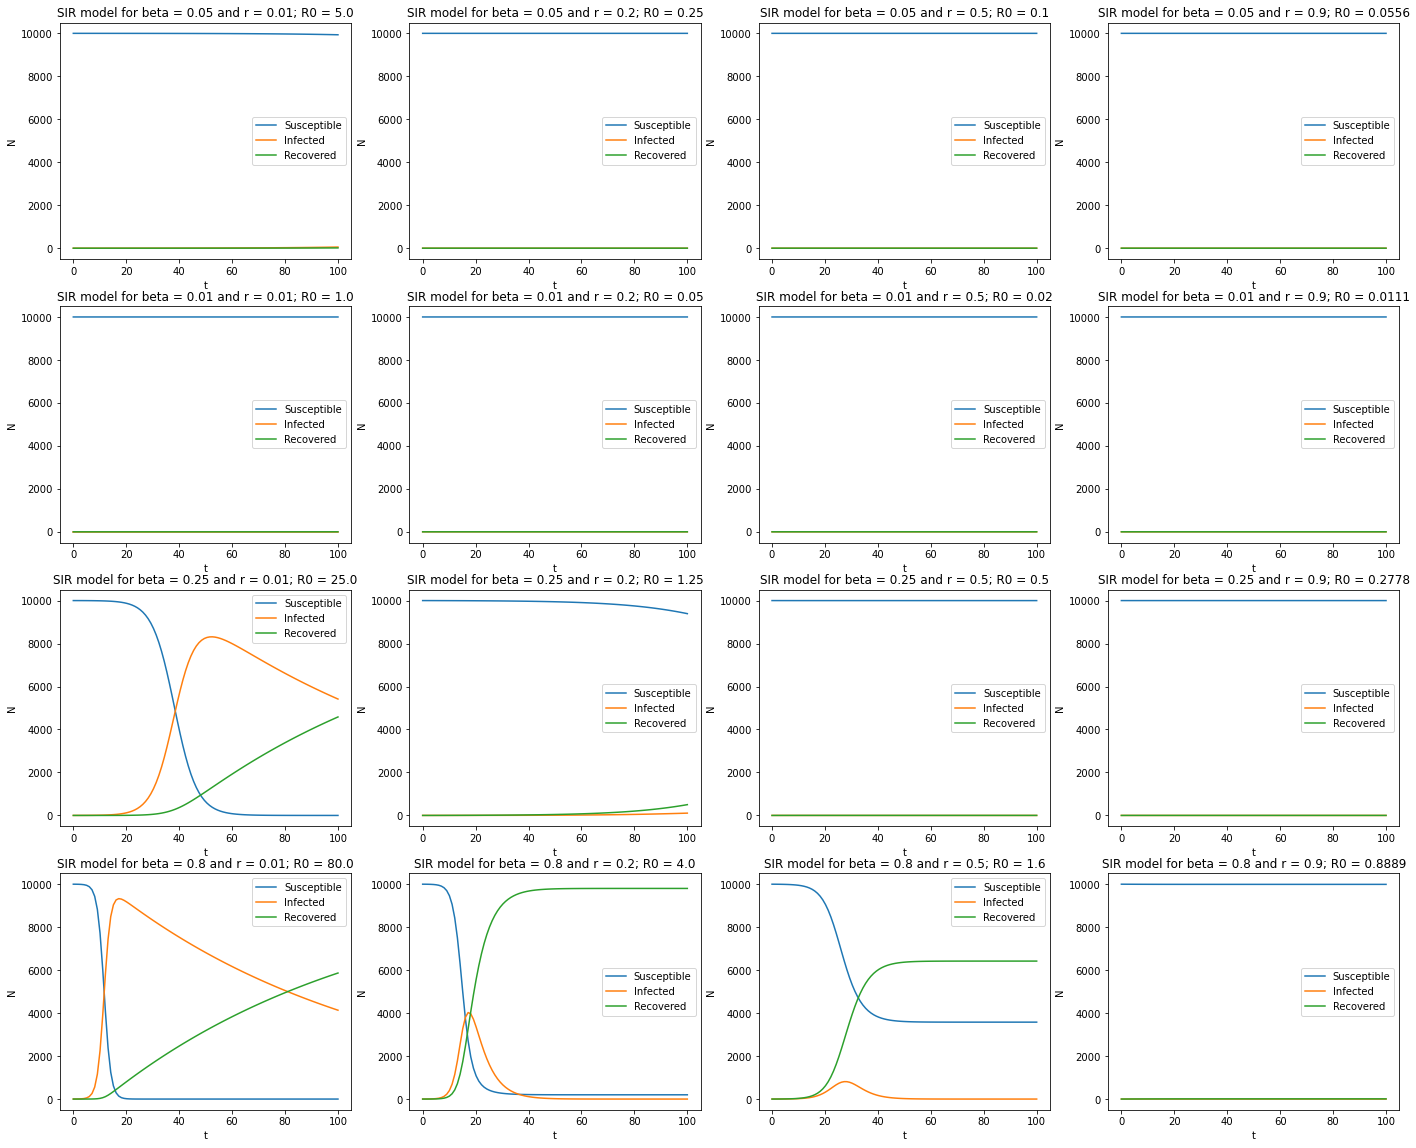

In [135]:
# solving SIR model numerically - results

IC = [N - 1, 1, 0] # [susceptible, infected, recovered]

R_0s = ['R0']
bs = ['beta']
rs2 = ['r']
res_threshold = ['result from plot']

fig, axes = plt.subplots(len(betas), len(rs), figsize=(24, 20))

for i, b in enumerate(betas):
    for j, r in enumerate(rs):
        SIR = odeint(sir, IC, t, args = (b, r, N))
        S, I, R = SIR.T
        R_0 = R0(b, r)
        
        ax = axes[i, j]
        ax.plot(t, S, label='Susceptible')
        ax.plot(t, I, label='Infected')
        ax.plot(t, R, label='Recovered')
        
        ax.set_xlabel('t')
        ax.set_ylabel('N')
        ax.set_title(f'SIR model for beta = {b} and r = {r}; R0 = {R_0}')

        ax.legend()

        R_0s.append(R_0)
        bs.append(b)
        rs2.append(r)
        
        # checking if there is an epidemic using commonly used threshold that is a fraction of the total population,
        # in this case set to 0.1 (10%) of the population
        
        max_infected = np.max(I)
        if max_infected > 0.1 * N:
            res_threshold.append('epidemic')
        else:
            res_threshold.append('no epidemic')

plt.show()

In [136]:
# checking if there is an epidemic is SIR model

res = ['result from R0']

for i in range(1, len(R_0s)):
    if R_0s[i] > 1:
        res.append('epidemic')
    else:
        res.append('no epidemic')
        
tbl = zip(bs, rs2, R_0s, res, res_threshold)

for i in tbl:
    print("{:<10} {:<10} {:<10} {:<18} {:<10}".format(*i))

beta       r          R0         result from R0     result from plot
0.05       0.01       5.0        epidemic           no epidemic
0.05       0.2        0.25       no epidemic        no epidemic
0.05       0.5        0.1        no epidemic        no epidemic
0.05       0.9        0.0556     no epidemic        no epidemic
0.01       0.01       1.0        no epidemic        no epidemic
0.01       0.2        0.05       no epidemic        no epidemic
0.01       0.5        0.02       no epidemic        no epidemic
0.01       0.9        0.0111     no epidemic        no epidemic
0.25       0.01       25.0       epidemic           epidemic  
0.25       0.2        1.25       epidemic           no epidemic
0.25       0.5        0.5        no epidemic        no epidemic
0.25       0.9        0.2778     no epidemic        no epidemic
0.8        0.01       80.0       epidemic           epidemic  
0.8        0.2        4.0        epidemic           epidemic  
0.8        0.5        1.6        epide

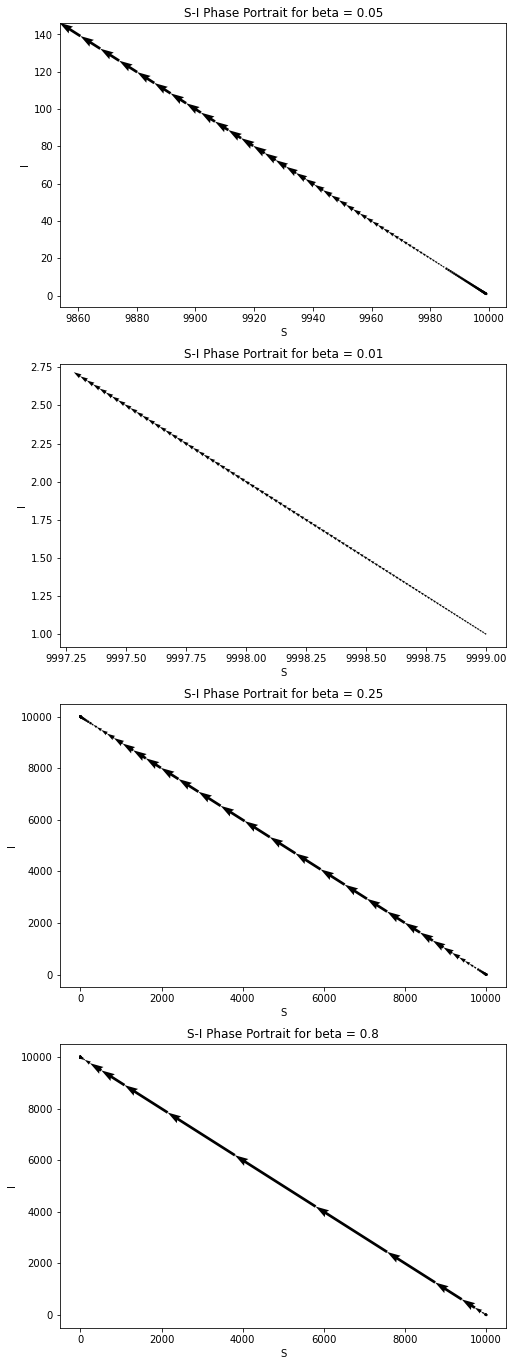

In [137]:
# solving SI model numerically - results

IC = [N - 1, 1] # [susceptible, infected, recovered]

fig, axes = plt.subplots(len(betas), 1, figsize=(8, 6*len(betas)))

for i, beta in enumerate(betas):
    SI = odeint(si, IC, t, args=(beta, N))
    S, I = SI.T
    
    ax = axes[i]
    ax.quiver(S[:-1], I[:-1], S[1:]-S[:-1], I[1:]-I[:-1], scale_units='xy', angles='xy', scale=1)
    
    ax.set_xlabel('S')
    ax.set_ylabel('I')
    ax.set_title(f'S-I Phase Portrait for beta = {beta}')
    
plt.show()

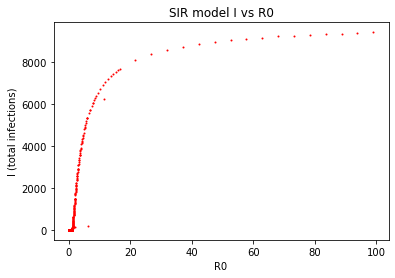

In [138]:
IC = [N - 1, 1, 0] # [susceptible, infected, recovered]

totalI = []
R0Vals = []

for b in newBetas:
    for r in newRs:
        SIR = odeint(sir, IC, t, args = (b, r, N))
        S, I, R = SIR.T
        totalI.append(np.max(I))
        R0Vals.append(R0(b, r))
        
plt.scatter(R0Vals, totalI, s = 1, c = 'red')
plt.xlabel('R0')
plt.ylabel('I (total infections)')
plt.title('SIR model I vs R0')
plt.show()